<a href="https://colab.research.google.com/github/CelikAbdullah/deep-learning-notebooks/blob/main/Deep%20Reinforcement%20Learning/Policy%20Based/VPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import time
from itertools import count

# Policy Network

This is the fully connected policy network, we will use in the VPG algorithm to learn the policy. It is the same network as in the REINFORCE algorithm:

In [ ]:
class PolicyNetwork(nn.Module):
  def __init__(self,
               input_dim,
               output_dim,
               hidden_dims=(32,32),
               activation_fc=F.relu):

    super(PolicyNetwork, self).__init__()

    # set the activation fct for the fully connected layer
    self.activation_fc = activation_fc

    # the input layer
    self.input_layer = nn.Linear(input_dim, hidden_dims[0])

    # the hidden layers
    self.hidden_layers = nn.ModuleList()
    for i in range(len(hidden_dims)-1):
      hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
      self.hidden_layers.append(hidden_layer)

    # the output layer
    self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

  def _format(self, state):
    x = state
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, dtype=torch.float32)
      x = x.unsqueeze(0)

    return x

  def forward(self, state):
    '''
    Define the forward pass.
    '''
    x = self._format(state)
    x = self.activation_fc(self.input_layer(x))

    for hidden_layer in self.hidden_layers:
      x = self.activation_fc(hidden_layer(x))

    return self.output_layer(x)

  def full_pass(self, state):
    # perform the forward pass to obtain the logits (preferences over the actions)
    # logits are interpreted to be the unnormalized (or not yet normalized) predictions
    # (or outputs) of a model
    logits = self.forward(state)

    # create a probability distribution using the logits
    dist = torch.distributions.Categorical(logits=logits)

    # sample an action from the probability distribution
    action = dist.sample()

    # get the log probabilities of the selected action
    logpa = dist.log_prob(action).unsqueeze(-1)

    # compute the entropy of the policy
    # high entropy when action probabilities are similar to each other
    # low entropy when 1 action has a very high probability & all other actions have low probability
    # the entropy will be used in the loss function
    entropy = dist.entropy().unsqueeze(-1)

    # return the selected action and its log probability
    return action.item(), logpa, entropy


  def select_action(self, state):
    '''
    Sample an action from the probability distribution.
    '''
    logits = self.forward(state)
    dist = torch.distributions.Categorical(logits=logits)
    action = dist.sample()
    return action.item()

  def select_greedy_action(self, state):
    '''
    Select a greedy action according to the policy.
    '''
    logits = self.forward(state)
    return np.argmax(logits.detach().numpy())

# The Value Network

This is the fully connected value network, we will use in the VPG algorithm to learn the state-value function:

In [ ]:
class ValueNetwork(nn.Module):
  def __init__(self,
               input_dim,
               hidden_dims=(32,32),
               activation_fc=F.relu):

    super(ValueNetwork, self).__init__()

    # set the activation fct for the activation layer
    self.activation_fc = activation_fc

    # the input layer
    self.input_layer = nn.Linear(input_dim, hidden_dims[0])

    # the hidden layer(s)
    self.hidden_layers = nn.ModuleList()

    for i in range(len(hidden_dims)-1):
      hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
      self.hidden_layers.append(hidden_layer)

    # the output layer
    # (only 1 output since the outcome of a state-value fct is a single value)
    self.output_layer = nn.Linear(hidden_dims[-1], 1)


  def _format(self, state):
    '''
    Format the given input (state).
    '''
    x = state

    # if state is not a PyTorch tensor
    if not isinstance(x, torch.Tensor):
      # convert it to a PyTorch tensor
      x = torch.tensor(x, dtype=torch.float32)
      # add a dimension to it
      x = x.unsqueeze(0)


    return x

  def forward(self, state):
    '''
    Forward pass.
    '''

    # bring the state into the right format
    x = self._format(state)

    # pass formatted state through the input layer & activation function
    x = self.activation_fc(self.input_layer(x))

    # pass output from input layer to the hidden layer(s)
    for hidden_layer in self.hidden_layers:
      x = self.activation_fc(hidden_layer(x))

    # pass output from hidden layer(s) to the output layer
    return self.output_layer(x)

# VPG

In the vanilla policy gradient (VPG) algorithm, we use the actual returns, such as in REINFORCE, and subtract the learned value function (baseline) to reduce the variance of the gradient.
Basically, we use the advantage function as the policy score.


Here, a definition of the true action-advantage function:

$a_\pi(s, a) = q_\pi(s,a) - v_\pi(s)$

We are able to approximate that function via the following:

$A(S_t, A_t) \approx R_t + \gamma R_{t+1} + ... + \gamma^{T-1}R_T - v_\pi(S_t)$

Since $G_t = R_t + \gamma R_{t+1} + ... + \gamma^{T-1}R_T$, we can also say:

$A(S_t, A_t) \approx G_t - v_\pi(S_t)$, whereas $G_t$ is the return from timestep $t$ to the last timestep $T$ and $v_\pi(S_t)$ is the estimated expected return from the state at timestep $t$.

The loss for the value function is the following:

$L_v(\phi) = \dfrac{1}{N} \sum_{n=0}^N [(G_t - V(S_t; \phi))^2]$

The loss for the policy is the following:

$L_\pi(\theta) = - \dfrac{1}{N} \sum_{n=0}^N [\underbrace{(G_t - V(S_t; \phi))}_\text{action-advantage fct} \underbrace{log\pi(A_t|S_t; \theta)}_\text{log probabilities of the actions}+ \beta \underbrace{ H(\pi(S_t; \theta))}_\text{entropy of the policy}]$

As you can notice, we encourage exploration by adding the entropy of the policy to the loss function. Recall that the evenly distributed actions result in a high entropy. That way, a policy with evenly distributed actions has a high entropy and therefore, it contributes to minimizing the loss.

As in REINFORCE, since we learn a stochastic policy, the exploration is on-policy. That is, exploration is taken care of by the policy itself because it is stochastic; it has randomness.

In [ ]:
class VPG():

  def __init__(self,
               env,
               policy_model,
               value_model,
               policy_optimizer,
               value_optimizer,
               policy_model_max_grad_norm,
               value_model_max_grad_norm,
               entropy_loss_weight,
               gamma,
               max_episodes = 10000,
               max_minutes = 10,
               goal_mean_reward=475):


    # set the attributes
    self.env = env
    self.policy_model = policy_model
    self.value_model = value_model
    self.policy_optimizer = policy_optimizer
    self.value_optimizer = value_optimizer
    self.policy_model_max_grad_norm = policy_model_max_grad_norm
    self.value_model_max_grad_norm = value_model_max_grad_norm
    self.entropy_loss_weight = entropy_loss_weight
    self.gamma = gamma
    self.max_episodes = max_episodes
    self.max_minutes = max_minutes
    self.goal_mean_100_reward = goal_mean_100_reward
    self.evaluation_scores = []


  def interaction(self, state):
    '''
    Interact with the environment.
    '''

    # pass the state through the policy network
    action, logpa, entropy = self.policy_model.full_pass(state)

    # perform the sampled action from the probability distribution in the environment
    new_state, reward, is_terminal, info = self.env.step(action)

    # check CartPole's built-in time limit
    is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']


    # save the log probability of the action
    self.logpas.append(logpa)
    # save the entropy of the policy
    self.entropies.append(entropy)
    # save the experienced reward after taking the selected action
    self.rewards.append(reward)
    # save the output of the model approximating the state-value fct
    self.values.append(self.value_model(state))


    return new_state, is_terminal, is_truncated


  def optimize(self):
    '''
    Optimize the policy network and the value network.
    '''

    # compute the number of rewards
    T = len(self.rewards)

    # compute the discounts for each reward
    discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)

    # compute the sum of the discounted returns for all time steps
    # this is the returns for every time step in the current episode
    # from the initial state at time step 0, to one before the terminal T
    returns = np.array([np.sum(discounts[:T-t] * self.rewards[t:]) for t in range(T)])

    # convert the discounts and returns to float tensors
    discounts = torch.FloatTensor(discounts[:-1]).unsqueeze(1)
    returns = torch.FloatTensor(returns[:-1]).unsqueeze(1)

    # concatenate the list of log probabilities, entropies and values
    self.logpas = torch.cat(self.logpas)
    self.entropies = torch.cat(self.entropies)
    self.values = torch.cat(self.values)


    # to further reduce the variance of the policy gradient, we use
    # an estimate of the action-advantage function instead of the
    # actual return
    # Adv = G - V whereas V is the baseline
    value_error = returns - self.values


    # policy loss is the same as in REINFORCE, except that we use the
    # value error to score the log probabilities of the actions
    policy_loss = -(discounts * value_error.detach() * self.logpas).mean()

    # compute the entropy loss which is the mean of the collected entropies
    entropy_loss = -self.entropies.mean()

    # compute the final policy loss
    # note:
    # the VPG and other policy-based algorithms learn on-policy &
    # introduce randomness and therefore exploration.
    # To promote randomness in stochastic policies, we add an entropy loss
    # to the loss function
    loss = policy_loss + self.entropy_loss_weight * entropy_loss

    # zero-out the gradients of the policy network
    self.policy_optimizer.zero_grad()
    # compute the gradients of the policy network
    loss.backward()

    # clip the weights of the policy network
    torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(),
                                   self.policy_model_max_grad_norm)
    # update the weights of the policy network
    self.policy_optimizer.step()


    # compute the value loss; the loss of the value network
    value_loss = value_error.pow(2).mul(0.5).mean()
    # zero-out the gradients of the value network
    self.value_optimizer.zero_grad()
    # compute the gradients of the value network
    value_loss.backward()
    # clip the weights of the value network
    torch.nn.utils.clip_grad_norm_(self.value_model.parameters(),
                                   self.value_model_max_grad_norm)
    # update the weights of the value network
    self.value_optimizer.step()

  def train(self):
    '''
    Train the VPG agent.
    '''

    # get the starting time of the training phase
    training_start = time.time()

    # for each episode do the following
    for episode in range(1, self.max_episodes + 1):

      # get the initial state
      state = self.env.reset()

      # is_terminal flag to indicate whether an episode is finished
      is_terminal = False

      # create the lists
      self.logpas, self.entropies, self.rewards, self.values = [], [], [], []

      # for each time step in the current episode
      for timestep in count():

        # interact with the environment
        state, is_terminal, is_truncated = self.interaction(state)

        # finish current episode if a terminal state is reached
        if is_terminal:
          break

      # handle a failure
      is_failure = is_terminal and not is_truncated
      next_value = 0 if is_failure else self.value_model(state).detach().item()
      self.rewards.append(next_value)

      # after episode is finished, optimize the model
      self.optimize()

      # compute the evaluation score
      evaluation_score = self.evaluate()
      # store the evaluation score
      self.evaluation_scores.append(evaluation_score)

      # compute the mean of the evaluation scores
      mean_100_eval_score = np.mean(self.evaluation_scores[-100:])

      # will be used to check if max minutes are exceeded
      wallclock_elapsed = time.time() - training_start

      # some flags to finish the training process
      reached_max_minutes = wallclock_elapsed >= self.max_minutes * 60
      reached_max_episodes = episode >= self.max_episodes
      reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward

      # check if training should be finished
      training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward

      # finish the training process
      if training_is_over:
        if reached_max_minutes: print('Max minutes are reached')
        if reached_max_episodes: print('Max episodes are reached')
        if reached_goal_mean_reward: print('Goal mean reward is reached')
        break


    # compute a final evaluation score
    final_evaluation_score = self.evaluate(episodes=100)
    print(f"Final_evaluation score: {final_evaluation_score}")

    self.env.close()
    del self.env

    return final_evaluation_score

  def evaluate(self, episodes=1, greedy=True):
    ''' Evaluate the model. '''

    # keep track of the rewards
    rewards = []

    # for each episode (default: 1) do the following
    for _ in range(episodes):
      # get the initial state
      state = self.env.reset()
      # set is_terminal flag to False
      is_terminal = False

      # append a 0 to rewards list
      rewards.append(0)

      # for each timestep of the current episode, do the following
      for _ in count():
        if greedy:
          # select a greedy action according to the policy.
          action = self.policy_model.select_greedy_action(state)
        else:
          # sample an action from the distribution
          action = self.policy_model.select_action(state)

        # take the action in the environment
        state, reward, is_terminal, _ = self.env.step(action)

        # save the reward
        rewards[-1] += reward

        # finish when terminal state is reached
        if is_terminal:
          break

    # return the mean of the rewards to the caller
    return np.mean(rewards)

Let's train the VPG agent:

In [ ]:
best_agent, best_eval_score = None, float('-inf')
SEEDS = (12, 34, 56, 78, 90)

# we let five VPG agents train, the one with the best evaluation score will be selected as the best one
# in each iteration, a different seed is used for creating the environment
for seed in SEEDS:
  # create an instance of the environment
  env = gym.make("CartPole-v1")
  env.seed(seed)

  # obtain the number of variables used in each state and the number of actions
  state_space = env.observation_space.shape[0]
  action_space = env.action_space.n

  # build the policy network
  policy_model = PolicyNetwork(state_space, action_space, hidden_dims=(128,64))
  policy_model_max_grad_norm = 1
  policy_optimizer= optim.Adam(policy_model.parameters(), lr=0.0005)

  # build the value network
  value_model = ValueNetwork(state_space, hidden_dims=(256,128))
  value_model_max_grad_norm = float('inf')
  value_optimizer= optim.RMSprop(value_model.parameters(), lr=0.0007)

  # define the weight for the entropy loss
  entropy_loss_weight = 0.001

  # define the our discount factor
  gamma = 1.00

  # define max minutes
  max_minutes = 10

  # define nr. of max episodes
  max_episodes = 10000

  # define mean reward value
  goal_mean_100_reward = 475

  # create the VPG agent
  agent = VPG(env,
              policy_model,
              value_model,
              policy_optimizer,
              value_optimizer,
              policy_model_max_grad_norm,
              value_model_max_grad_norm,
              entropy_loss_weight,
              gamma,
              max_episodes,
              max_minutes,
              goal_mean_100_reward
              )

  # let the VPG agent train
  final_evaluation_score = agent.train()

  # check if current agent performed better
  if final_evaluation_score > best_eval_score:
    best_eval_score = final_evaluation_score
    best_agent = agent

Goal mean reward is reached
Final_evaluation score: 495.23
Goal mean reward is reached
Final_evaluation score: 479.97
Goal mean reward is reached
Final_evaluation score: 488.62
Goal mean reward is reached
Final_evaluation score: 499.09
Goal mean reward is reached
Final_evaluation score: 498.01


# Save the model

In [ ]:
torch.save(best_agent.policy_model.state_dict(), "/content/drive/MyDrive/VPG/VPG_agent_final.pt")

# Visualization

In [ ]:
import os
import imageio
from PIL import Image as Im
import PIL.ImageDraw as ImageDraw
from IPython import display

In [ ]:
env = gym.make("CartPole-v1")
model = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, hidden_dims=(128,64))
model.load_state_dict(torch.load("/content/drive/MyDrive/VPG/VPG_agent_final.pt"))
model.eval()

PolicyNetwork(
  (input_layer): Linear(in_features=4, out_features=128, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=128, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
def create_gif(env, episodes):
  # list to keep track of frames
  frames = []

  for episode in range(1, episodes + 1):
    # get the initial state
    state = env.reset()

    # for each timestep, do the following
    for t in range(500):

      # select an action from the probability distribution
      action = model.select_action(state)

      # get the frame & store it
      frame = env.render(mode='rgb_array')

      # prepare the frame
      im = Im.fromarray(frame)
      drawer = ImageDraw.Draw(im)
      if np.mean(im) < 128:
        text_color = (255,255,255)
      else:
        text_color = (0,0,0)
        drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode+1}', fill=text_color)
        drawer.text((im.size[0]/20,im.size[1]/8), f'Timestep: {t+1}', fill=text_color)

      # store the frame
      frames.append(im)

      # take the action in the environment
      state, _, is_terminal, _ = env.step(action)

      # if we land at a terminal state, break
      if is_terminal:
        break

    # close the environment
    env.close()

    # create the gif
    imageio.mimwrite(os.path.join('/content/drive/MyDrive/Gif/', 'VPG_agent.gif'), frames, fps=60)

In [ ]:
episodes = 5
env = gym.make('CartPole-v1')
create_gif(env, episodes)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


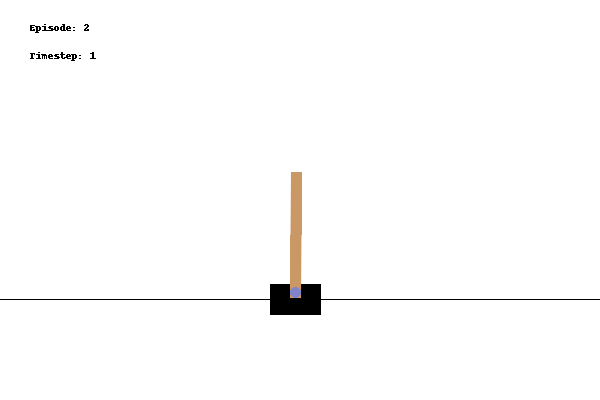

In [ ]:
from IPython import display
display.Image(open('/content/drive/MyDrive/Gif/VPG_agent.gif','rb').read())